In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import joblib  # For saving the model

In [63]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
# Load datasets
train_path = "/content/drive/MyDrive/CS_dataset/cs-training.csv"  # Store dataset in Google Drive
test_path = "/content/drive/MyDrive/CS_dataset/cs-test.csv"  # Store test dataset in Google Drive

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

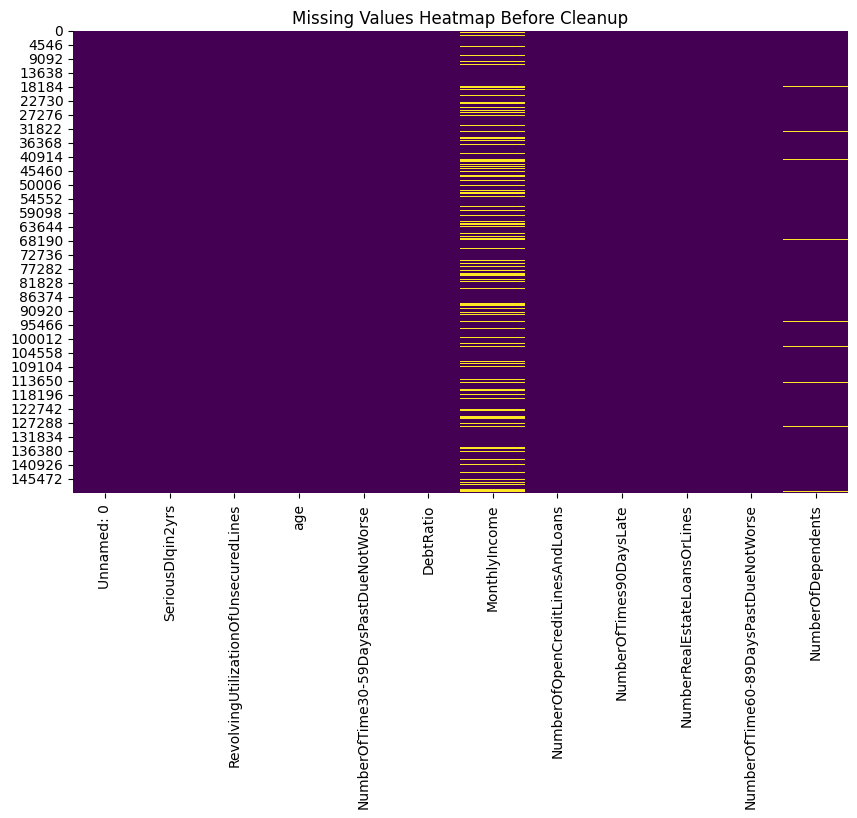

In [65]:
# Data Visualization Before Cleanup
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap Before Cleanup")
plt.show()

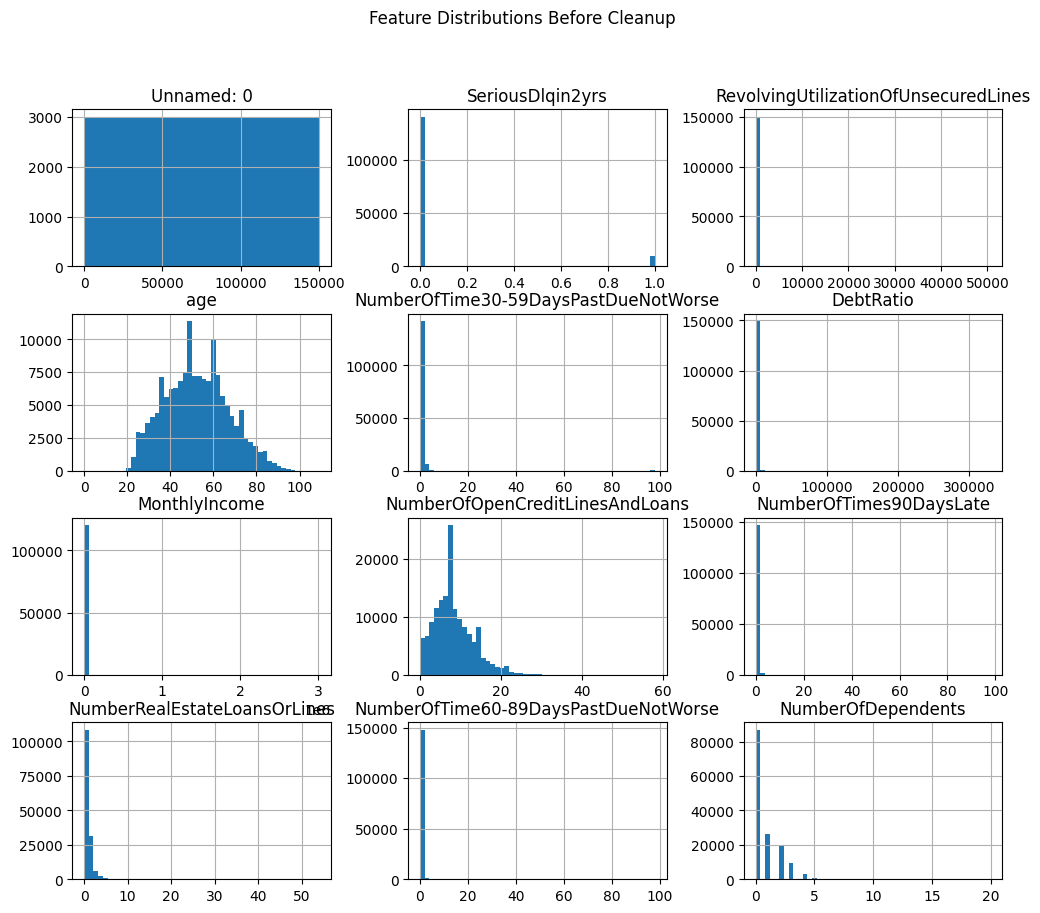

In [66]:
train_df.hist(figsize=(12, 10), bins=50)
plt.suptitle("Feature Distributions Before Cleanup")
plt.show()

In [67]:
# Data Cleanup
train_df.drop(columns=["Unnamed: 0"], inplace=True)  # Remove index column
imputer_income = SimpleImputer(strategy='median')
train_df['MonthlyIncome'] = imputer_income.fit_transform(train_df[['MonthlyIncome']])
train_df['NumberOfDependents'].fillna(train_df['NumberOfDependents'].median(), inplace=True)
train_df['MonthlyIncome'].fillna(train_df['MonthlyIncome'].median(), inplace=True)

<ipython-input-67-36c1a33528c0>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['NumberOfDependents'].fillna(train_df['NumberOfDependents'].median(), inplace=True)
<ipython-input-67-36c1a33528c0>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df

In [68]:
# Check for outliers and Clip extreme values
train_df['RevolvingUtilizationOfUnsecuredLines'] = train_df['RevolvingUtilizationOfUnsecuredLines'].clip(upper=1)
train_df['DebtRatio'] = train_df['DebtRatio'].clip(upper=train_df['DebtRatio'].quantile(0.99))
train_df['age'] = train_df['age'].clip(lower=18)

In [69]:
# Remove Duplicates
train_df.drop_duplicates(inplace=True)

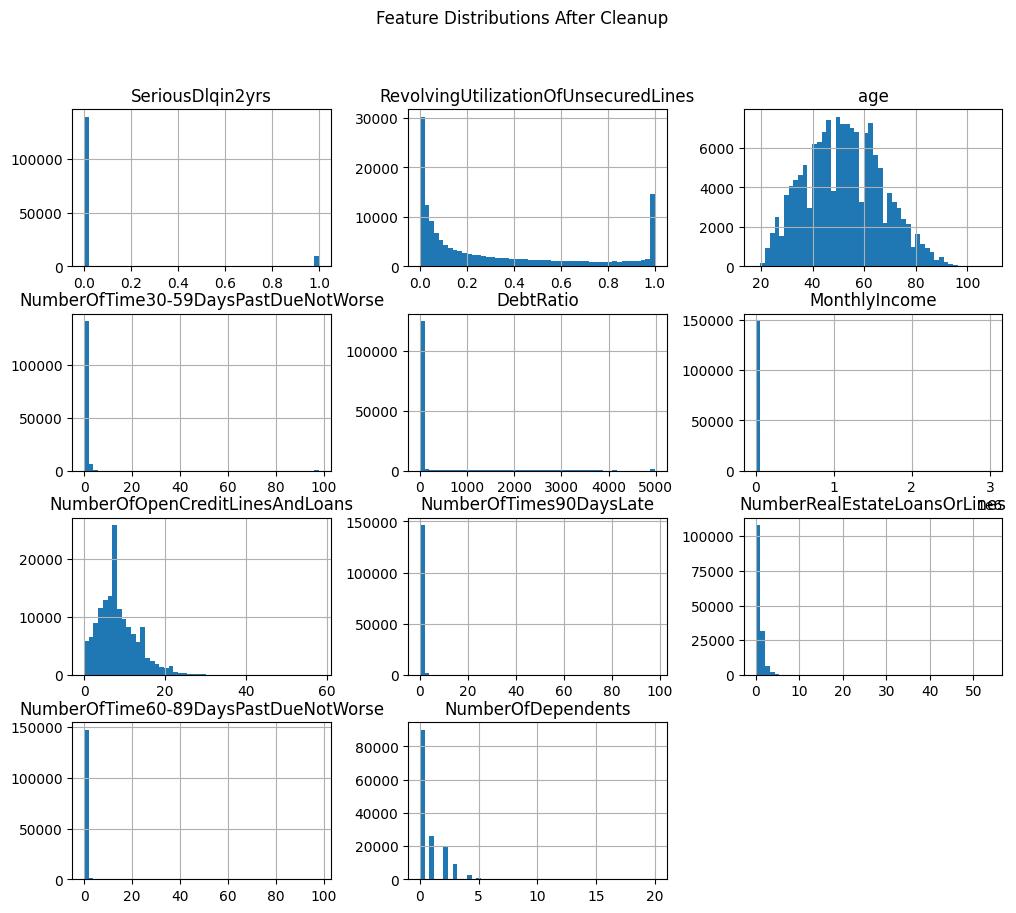

In [70]:
train_df.hist(figsize=(12, 10), bins=50)
plt.suptitle("Feature Distributions After Cleanup")
plt.show()

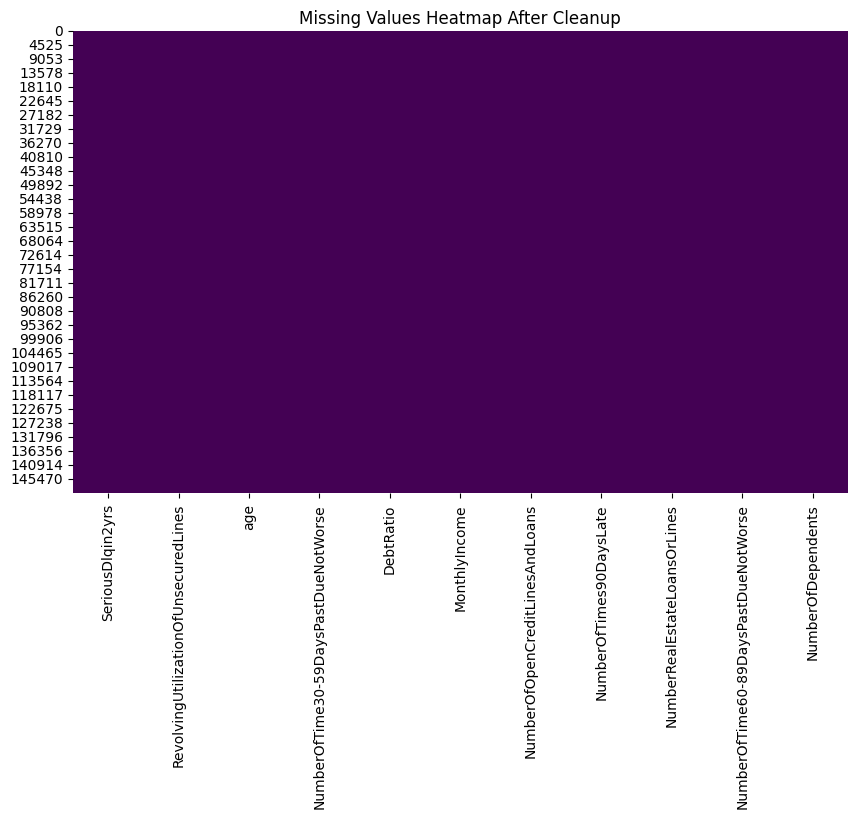

In [71]:
# Data Visualization Before Cleanup
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap After Cleanup")
plt.show()

In [72]:
# Feature and target selection for training
X_train = train_df.drop(columns=["SeriousDlqin2yrs"])
y_train = train_df["SeriousDlqin2yrs"]

In [73]:
# Ensure Consistent Data Types (Convert Categorical if Needed)
X = pd.get_dummies(X_train)

In [74]:
# Train-test split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [75]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [76]:
# Logistic Regression Model with class weight adjustment
model = LogisticRegression(max_iter=500, class_weight='balanced', C=0.5)  # Using balanced class weight
model.fit(X_train_scaled, y_train)

LogisticRegression(C=0.5, class_weight='balanced', max_iter=500)

In [77]:
# Predictions on validation dataset (probabilities, not just labels)
y_pred_valid = model.predict(X_valid)
y_prob_valid = model.predict_proba(X_valid)[:, 1]  # Probability scores

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [78]:
# Model Evaluation
accuracy = accuracy_score(y_valid, y_pred_valid)
roc_auc = roc_auc_score(y_valid, y_prob_valid)
report = classification_report(y_valid, (y_prob_valid > 0.5))  # Converting prob > 0.5 to label for evaluation

In [79]:
# Output results
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print("Classification Report:\n", report)


Accuracy: 0.9322
ROC-AUC Score: 0.5416
Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96     27822
           1       0.57      0.00      0.00      2025

    accuracy                           0.93     29847
   macro avg       0.75      0.50      0.48     29847
weighted avg       0.91      0.93      0.90     29847



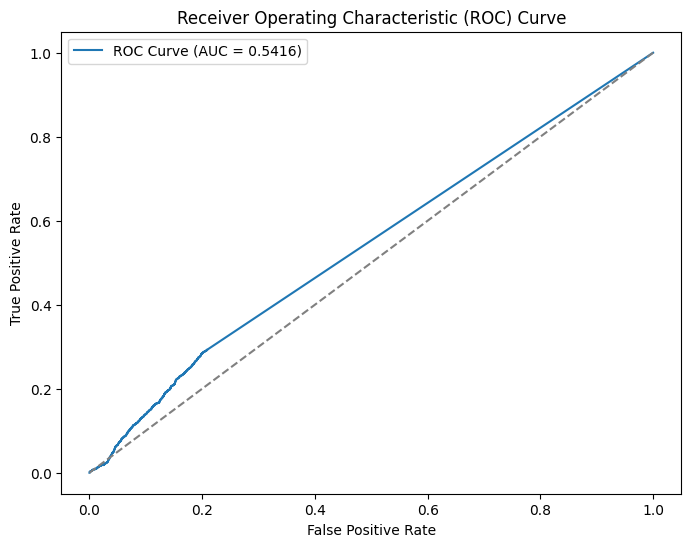

In [80]:
# Plot ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_valid, y_prob_valid)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [81]:
# Save the model for future use
joblib.dump(model, '/content/drive/MyDrive/CS_dataset/logistic_model.pkl')
joblib.dump(scaler, '/content/drive/MyDrive/CS_dataset/scaler.pkl')

['/content/drive/MyDrive/CS_dataset/scaler.pkl']

In [82]:
# Data Cleanup for Test Dataset
test_df.drop(columns=["Unnamed: 0"], inplace=True)  # Remove index column

In [83]:
# Handle missing values for test dataset (same strategy as training)
test_df['MonthlyIncome'] = imputer_income.transform(test_df[['MonthlyIncome']])
test_df['NumberOfDependents'].fillna(test_df['NumberOfDependents'].median(), inplace=True)

<ipython-input-83-4b5bc233ffa0>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['NumberOfDependents'].fillna(test_df['NumberOfDependents'].median(), inplace=True)


In [84]:
# Clip extreme values for test dataset (same as training)
test_df['RevolvingUtilizationOfUnsecuredLines'] = test_df['RevolvingUtilizationOfUnsecuredLines'].clip(upper=1)
test_df['DebtRatio'] = test_df['DebtRatio'].clip(upper=test_df['DebtRatio'].quantile(0.99))
test_df['age'] = test_df['age'].clip(lower=18)

In [85]:
# Convert categorical variables to dummy variables for test dataset
test_df = pd.get_dummies(test_df)

In [86]:
# Ensure that the test dataset has the same features as the training dataset
X_test = test_df.reindex(columns=X_train.columns, fill_value=0)

In [87]:
# Scale the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

In [88]:
# Make probability predictions on the test dataset (probabilities, not just labels)
y_prob_test = model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for class 1

In [89]:
# Output probabilities for the test dataset (values between 0 and 1)
print(f"Probabilities for the test dataset (between 0 and 1):\n {y_prob_test}")

Probabilities for the test dataset (between 0 and 1):
 [0.62119551 0.48614577 0.20297154 ... 0.11959408 0.28488127 0.4948331 ]


In [90]:
# Save probabilities to CSV (with index and predicted probability values)
probabilities_df = pd.DataFrame({'Id': test_df.index, 'Predicted_Prob_SeriousDlqin2yrs': y_prob_test})
probabilities_df.to_csv('/content/drive/MyDrive/CS_dataset/test_probabilities.csv', index=False)

Top 10 important features:
                                Feature  Importance
2  NumberOfTime30-59DaysPastDueNotWorse    1.623727
6               NumberOfTimes90DaysLate    1.523176
0  RevolvingUtilizationOfUnsecuredLines    0.806292
1                                   age    0.289058
4                         MonthlyIncome    0.197898
5       NumberOfOpenCreditLinesAndLoans    0.155466
7          NumberRealEstateLoansOrLines    0.111162
8  NumberOfTime60-89DaysPastDueNotWorse    0.109580
3                             DebtRatio    0.079758
9                    NumberOfDependents    0.028208


<ipython-input-91-833fb5d38fa5>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10), palette='viridis')


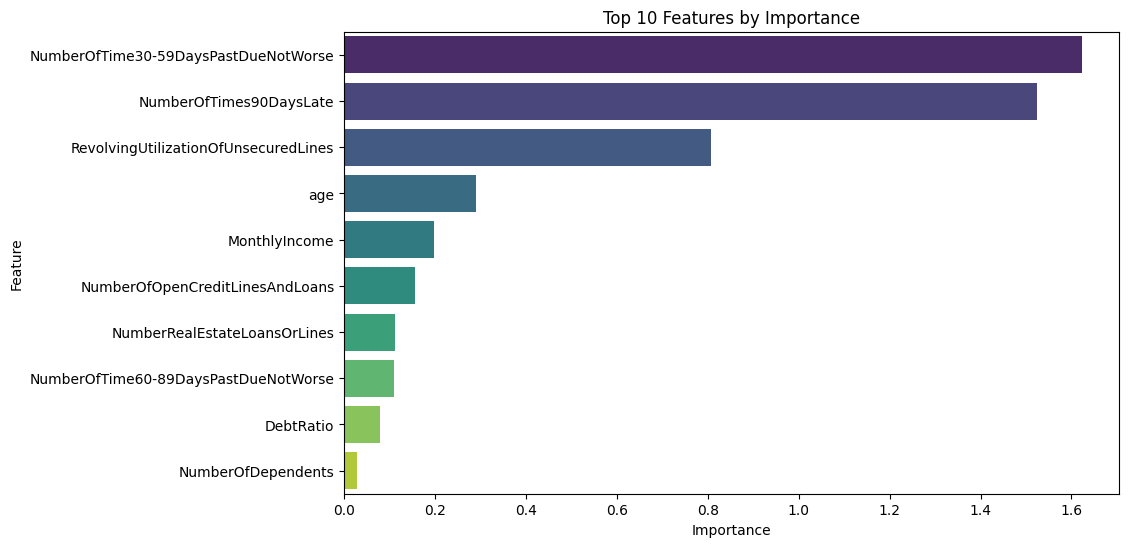

In [91]:
# Extracting coefficients for feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(model.coef_[0])  # Absolute value of the coefficients
})

# Sorting features based on importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Display top 10 important features
print("Top 10 important features:")
print(feature_importance.head(10))

# Visualizing feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10), palette='viridis')
plt.title('Top 10 Features by Importance')
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has fe

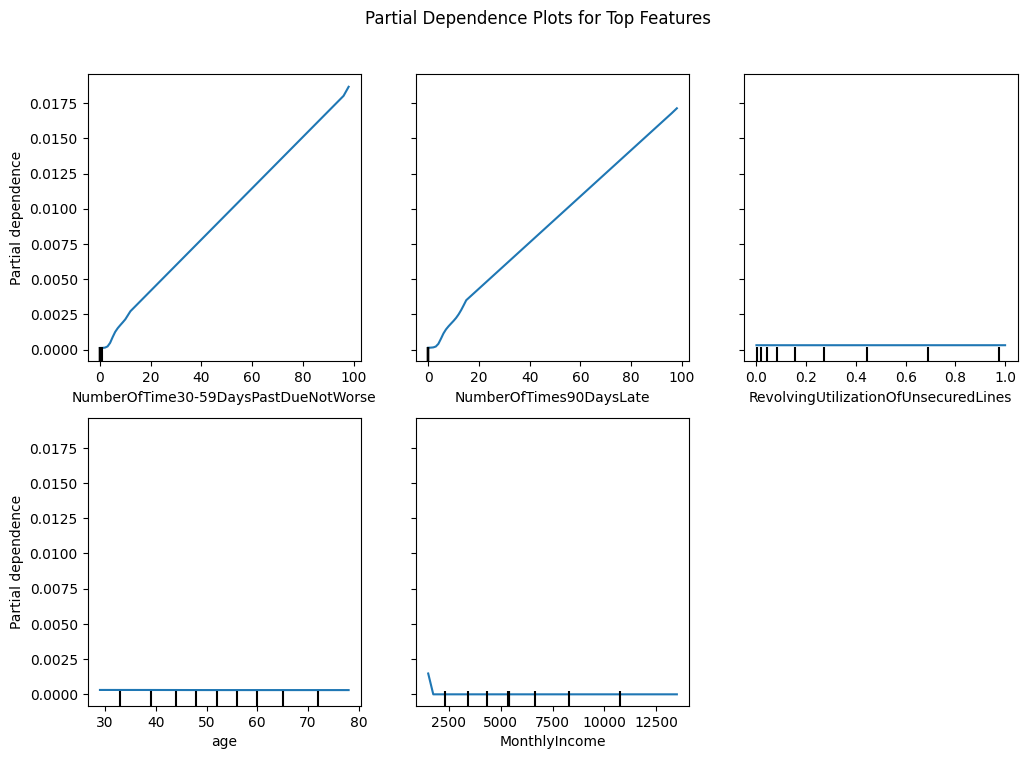

In [92]:
from sklearn.inspection import PartialDependenceDisplay

# Plot PDPs for top 5 features using PartialDependenceDisplay
top_features = feature_importance['Feature'].head(5).values

# Generate the Partial Dependence Plots
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(model, X_train, features=top_features, ax=ax, grid_resolution=50)
plt.suptitle('Partial Dependence Plots for Top Features')
plt.subplots_adjust(top=0.9)
plt.show()
